# Generative Adversarial Networks (GANs)


## Setup

In [1]:
from __future__ import print_function, division
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# A bunch of utility functions

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params():
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(x.get_shape().as_list()) for x in tf.global_variables()])
    return param_count


def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

answers = np.load('gan-checks-tf.npz')


## Dataset
 GANs are notoriously finicky with hyperparameters, and also require many training epochs. In order to make this assignment approachable without a GPU, we will be working on the MNIST dataset, which is 60,000 training and 10,000 test images. Each picture contains a centered image of white digit on black background (0 through 9). This was one of the first datasets used to train convolutional neural networks and it is fairly easy -- a standard CNN model can easily exceed 99% accuracy. 

To simplify our code here, we will use the TensorFlow MNIST wrapper, which downloads and loads the MNIST dataset. See the [documentation](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/learn/python/learn/datasets/mnist.py) for more information about the interface. The default parameters will take 5,000 of the training examples and place them into a validation dataset. The data will be saved into a folder called `MNIST_data`. 

**Heads-up**: The TensorFlow MNIST wrapper returns images as vectors. That is, they're size (batch, 784). If you want to treat them as images, we have to resize them to (batch,28,28) or (batch,28,28,1). They are also type np.float32 and bounded [0,1]. 

Extracting ./a3/cs231n/datasets/MNIST_data\train-images-idx3-ubyte.gz
Extracting ./a3/cs231n/datasets/MNIST_data\train-labels-idx1-ubyte.gz
Extracting ./a3/cs231n/datasets/MNIST_data\t10k-images-idx3-ubyte.gz
Extracting ./a3/cs231n/datasets/MNIST_data\t10k-labels-idx1-ubyte.gz


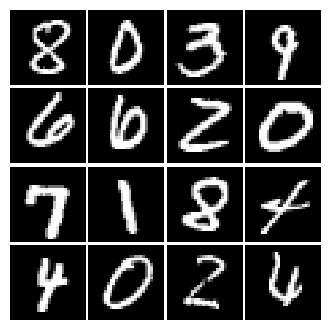

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./a3/cs231n/datasets/MNIST_data', one_hot=False)

# show a batch
show_images(mnist.train.next_batch(16)[0])

## LeakyReLU
In the cell below, you should implement a LeakyReLU. See the [class notes](http://cs231n.github.io/neural-networks-1/) (where alpha is small number) or equation (3) in [this paper](http://ai.stanford.edu/~amaas/papers/relu_hybrid_icml2013_final.pdf). LeakyReLUs keep ReLU units from dying and are often used in GAN methods (as are maxout units, however those increase model size and therefore are not used in this notebook).

HINT: You should be able to use `tf.maximum`

In [3]:
def leaky_relu(x, alpha=0.01):
    """Compute the leaky ReLU activation function.
    
    Inputs:
    - x: TensorFlow Tensor with arbitrary shape
    - alpha: leak parameter for leaky ReLU
    
    Returns:
    TensorFlow Tensor with the same shape as x
    """
    # TODO: implement leaky ReLU
    pass

    tzeros = tf.zeros_like(x)
    
    tpos = tf.where(x >= tzeros, x, tzeros)
    tneg = tf.where(x < tzeros, x, tzeros)
    
    lx = (alpha * tneg) + tpos
    return lx

Test your leaky ReLU implementation. You should get errors < 1e-10

In [4]:
def test_leaky_relu(x, y_true):
    tf.reset_default_graph()
    with get_session() as sess:
        y_tf = leaky_relu(tf.constant(x))
        y = sess.run(y_tf)
        print('Maximum error: %g'%rel_error(y_true, y))

test_leaky_relu(answers['lrelu_x'], answers['lrelu_y'])

Maximum error: 0


## Random Noise
Generate a TensorFlow `Tensor` containing uniform noise from -1 to 1 with shape `[batch_size, dim]`.

In [5]:
def sample_noise(batch_size, dim):
    """Generate random uniform noise from -1 to 1.
    
    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the the noise to generate
    
    Returns:
    TensorFlow Tensor containing uniform noise in [-1, 1] with shape [batch_size, dim]
    """
    # TODO: sample and return noise
    pass

    tnoise = tf.random_uniform([batch_size, dim], minval=-1, maxval=1)
    return tnoise


Make sure noise is the correct shape and type:

In [6]:
def test_sample_noise():
    batch_size = 3
    dim = 4
    tf.reset_default_graph()
    with get_session() as sess:
        z = sample_noise(batch_size, dim)
        # Check z has the correct shape
        assert z.get_shape().as_list() == [batch_size, dim]
        # Make sure z is a Tensor and not a numpy array
        assert isinstance(z, tf.Tensor)
        # Check that we get different noise for different evaluations
        z1 = sess.run(z)
        z2 = sess.run(z)
        assert not np.array_equal(z1, z2)
        # Check that we get the correct range
        assert np.all(z1 >= -1.0) and np.all(z1 <= 1.0)
        print("All tests passed!")
    
test_sample_noise()

All tests passed!


## Discriminator
Our first step is to build a discriminator. You should use the layers in `tf.layers` to build the model.
All fully connected layers should include bias terms.

Architecture:
 * Fully connected layer from size 784 to 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer from 256 to 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer from 256 to 1
 
The output of the discriminator should have shape `[batch_size, 1]`, and contain real numbers corresponding to the scores that each of the `batch_size` inputs is a real image.

In [7]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        # TODO: implement architecture
        pass        
        layer1 = tf.layers.dense(inputs=x, units=256, use_bias=True, activation=leaky_relu)
        layer2 = tf.layers.dense(inputs=layer1, units=256, use_bias=True, activation=leaky_relu)
        
        # Logits Layer
        logits = tf.layers.dense(inputs=layer2, units=1, use_bias=True)

        return logits

Test to make sure the number of parameters in the discriminator is correct:

In [8]:
def test_discriminator(true_count=267009):
    tf.reset_default_graph()
    with get_session() as sess:
        y = discriminator(tf.ones((2, 784)))
        cur_count = count_params()
        if cur_count != true_count:
            print('Incorrect number of parameters in discriminator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
        else:
            print('Correct number of parameters in discriminator.')
        
test_discriminator()

Correct number of parameters in discriminator.


## Generator
Now to build a generator. You should use the layers in `tf.layers` to construct the model. All fully connected layers should include bias terms.

Architecture:
 * Fully connected layer from tf.shape(z)[1] (the number of noise dimensions) to 1024
 * ReLU
 * Fully connected layer from 1024 to 1024 
 * ReLU
 * Fully connected layer from 1024 to 784
 * TanH (To restrict the output to be [-1,1])

In [9]:
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        # TODO: implement architecture
        pass
    
        layer1 = tf.layers.dense(inputs=z, units=1024, use_bias=True, activation=tf.nn.relu)
        layer2 = tf.layers.dense(inputs=layer1, units=1024, use_bias=True, activation=tf.nn.relu)
    
        # Logits Layer
        img = tf.layers.dense(inputs=layer2, units=784, use_bias=True, activation=tf.nn.tanh)
    
        return img

Test to make sure the number of parameters in the generator is correct:

In [10]:
def test_generator(true_count=1858320):
    tf.reset_default_graph()
    with get_session() as sess:
        y = generator(tf.ones((1, 4)))
        cur_count = count_params()
        if cur_count != true_count:
            print('Incorrect number of parameters in generator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
        else:
            print('Correct number of parameters in generator.')
        
test_generator()

Correct number of parameters in generator.


# GAN Loss

Compute the generator and discriminator loss. The generator loss is:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
Note that these are negated from the equations presented earlier as we will be *minimizing* these losses.

**HINTS**: Use [tf.ones_like](https://www.tensorflow.org/api_docs/python/tf/ones_like) and [tf.zeros_like](https://www.tensorflow.org/api_docs/python/tf/zeros_like) to generate labels for your discriminator. Use [sigmoid_cross_entropy loss](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) to help compute your loss function. Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing.

In [11]:
def gan_loss(logits_real, logits_fake):
    """Compute the GAN loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    D_loss = None
    G_loss = None
    pass
    
    # G loss
    G_loss = -tf.reduce_mean(tf.log(tf.nn.sigmoid(logits_fake)))
    
    # D loss
    t1 = -tf.reduce_mean(tf.log(tf.nn.sigmoid(logits_real)))
    t2 = -tf.reduce_mean(tf.log(1 - tf.nn.sigmoid(logits_fake)))    
    D_loss = t1 + t2
    
    return D_loss, G_loss

Test your GAN loss. Make sure both the generator and discriminator loss are correct. You should see errors less than 1e-5.

In [12]:
def test_gan_loss(logits_real, logits_fake, d_loss_true, g_loss_true):
    tf.reset_default_graph()
    with get_session() as sess:
        d_loss, g_loss = sess.run(gan_loss(tf.constant(logits_real), tf.constant(logits_fake)))
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_gan_loss(answers['logits_real'], answers['logits_fake'],
              answers['d_loss_true'], answers['g_loss_true'])

Maximum error in d_loss: 0
Maximum error in g_loss: 7.19722e-17


# Optimizing our loss
Make an `AdamOptimizer` with a 1e-3 learning rate, beta1=0.5 to mininize G_loss and D_loss separately. The trick of decreasing beta was shown to be effective in helping GANs converge in the [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498) paper. In fact, with our current hyperparameters, if you set beta1 to the Tensorflow default of 0.9, there's a good chance your discriminator loss will go to zero and the generator will fail to learn entirely. In fact, this is a common failure mode in GANs; if your D(x) learns to be too fast (e.g. loss goes near zero), your G(z) is never able to learn. Often D(x) is trained with SGD with Momentum or RMSProp instead of Adam, but here we'll use Adam for both D(x) and G(z). 

In [13]:
# TODO: create an AdamOptimizer for D_solver and G_solver
def get_solvers(learning_rate=1e-3, beta1=0.5):
    """Create solvers for GAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)
    
    Returns:
    - D_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    - G_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    """
    D_solver = None
    G_solver = None
    pass
    D_solver = tf.train.AdamOptimizer(learning_rate=1e-3, beta1=0.5)
    G_solver = tf.train.AdamOptimizer(learning_rate=1e-3, beta1=0.5)
    return D_solver, G_solver

## Putting it all together
Now just a bit of Lego Construction.. Read this section over carefully to understand how we'll be composing the generator and discriminator

In [14]:
tf.reset_default_graph()

# number of images for each batch
batch_size = 128
# our noise dimension
noise_dim = 96

# placeholder for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
# random noise fed into our generator
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 

# get our solver
D_solver, G_solver = get_solvers()

# get our loss
D_loss, G_loss = gan_loss(logits_real, logits_fake)

# setup training steps
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'generator')

# Training a GAN!
Well that wasn't so hard, was it? In the iterations in the low 100s you should see black backgrounds, fuzzy shapes as you approach iteration 1000, and decent shapes, about half of which will be sharp and clearly recognizable as we pass 3000. In our case, we'll simply train D(x) and G(z) with one batch each every iteration. However, papers often experiment with different schedules of training D(x) and G(z), sometimes doing one for more steps than the other, or even training each one until the loss gets "good enough" and then switching to training the other. 

In [15]:
# a giant helper function
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              show_every=250, print_every=50, batch_size=128, num_epoch=10):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    # compute the number of iterations we need
    max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
    for it in range(max_iter):
        # every show often, show a sample result
        if it % show_every == 0:
            samples = sess.run(G_sample)
            fig = show_images(samples[:16])
            plt.show()
            print()
        # run a batch of data through the network
        minibatch,minbatch_y = mnist.train.next_batch(batch_size)
        _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: minibatch})
        _, G_loss_curr = sess.run([G_train_step, G_loss])

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}, D: {:.4}, G:{:.4}'.format(it,D_loss_curr,G_loss_curr))
    print('Final images')
    samples = sess.run(G_sample)

    fig = show_images(samples[:16])
    plt.show()

#### Train your GAN! This should take about 10 minutes on a CPU, or less than a minute on GPU.

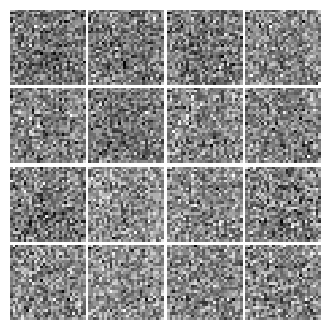


Iter: 0, D: 1.372, G:0.781
Iter: 50, D: 0.2606, G:1.658
Iter: 100, D: 0.426, G:1.447
Iter: 150, D: 1.54, G:1.114
Iter: 200, D: 1.007, G:1.591


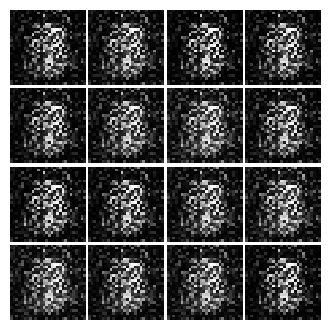


Iter: 250, D: 1.451, G:1.007
Iter: 300, D: 1.265, G:0.773
Iter: 350, D: 1.6, G:0.9374
Iter: 400, D: 1.417, G:0.8159
Iter: 450, D: 1.382, G:0.928


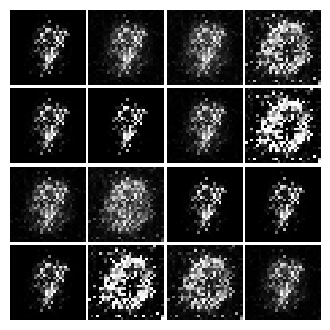


Iter: 500, D: 1.306, G:1.047
Iter: 550, D: 1.156, G:1.151
Iter: 600, D: 1.176, G:1.104
Iter: 650, D: 1.091, G:0.8112
Iter: 700, D: 1.359, G:1.192


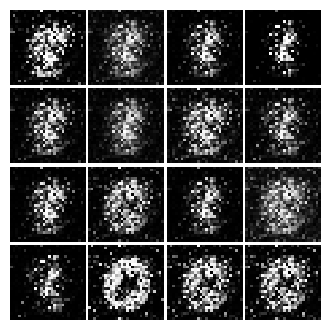


Iter: 750, D: 1.284, G:1.129
Iter: 800, D: 1.101, G:1.115
Iter: 850, D: 1.059, G:1.208
Iter: 900, D: 1.748, G:0.4846
Iter: 950, D: 1.391, G:0.6395


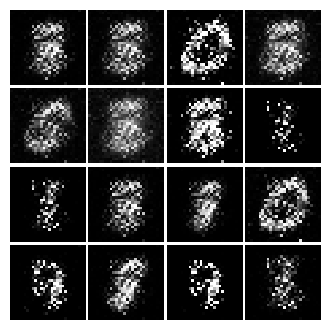


Iter: 1000, D: 1.22, G:0.8759
Iter: 1050, D: 1.376, G:1.2
Iter: 1100, D: 1.162, G:0.9969
Iter: 1150, D: 1.166, G:1.066
Iter: 1200, D: 1.106, G:1.011


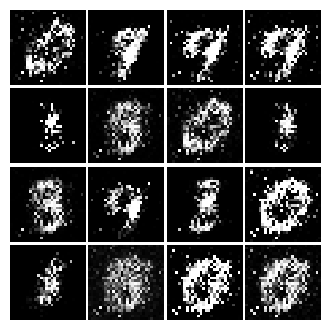


Iter: 1250, D: 1.246, G:1.281
Iter: 1300, D: 1.25, G:0.817
Iter: 1350, D: 1.412, G:0.9271
Iter: 1400, D: 1.371, G:0.9761
Iter: 1450, D: 1.087, G:1.808


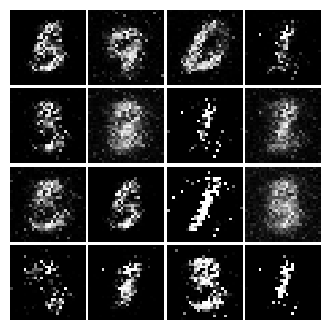


Iter: 1500, D: 1.281, G:1.055
Iter: 1550, D: 1.259, G:1.211
Iter: 1600, D: 1.274, G:0.9038
Iter: 1650, D: 1.292, G:0.7648
Iter: 1700, D: 1.459, G:0.7078


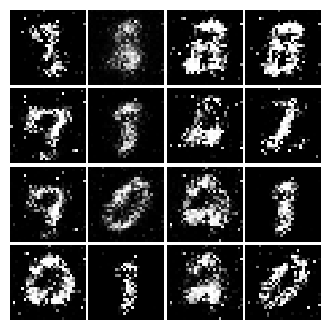


Iter: 1750, D: 1.234, G:1.029
Iter: 1800, D: 1.237, G:0.9382
Iter: 1850, D: 1.177, G:0.9853
Iter: 1900, D: 1.532, G:1.201
Iter: 1950, D: 1.158, G:1.045


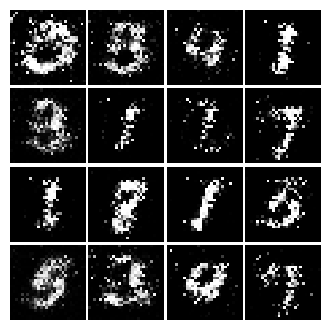


Iter: 2000, D: 1.31, G:0.9173
Iter: 2050, D: 1.233, G:1.075
Iter: 2100, D: 1.272, G:0.9712
Iter: 2150, D: 1.339, G:0.9548
Iter: 2200, D: 1.342, G:0.7624


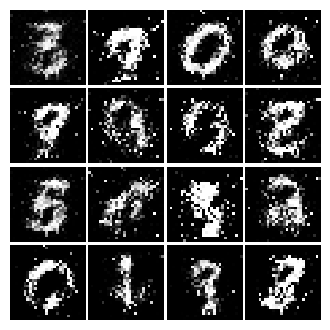


Iter: 2250, D: 1.385, G:0.8217
Iter: 2300, D: 1.301, G:0.8427
Iter: 2350, D: 1.322, G:0.7969
Iter: 2400, D: 1.349, G:0.8569
Iter: 2450, D: 1.381, G:0.8284


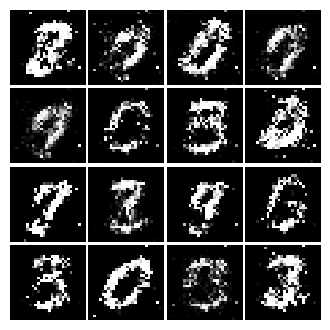


Iter: 2500, D: 1.3, G:0.8322
Iter: 2550, D: 1.429, G:0.7823
Iter: 2600, D: 1.314, G:0.8237
Iter: 2650, D: 1.375, G:0.8288
Iter: 2700, D: 1.301, G:0.8551


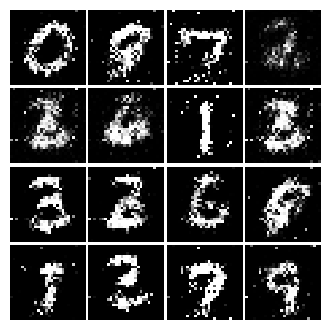


Iter: 2750, D: 1.328, G:0.8224
Iter: 2800, D: 1.345, G:0.9884
Iter: 2850, D: 1.267, G:0.9595
Iter: 2900, D: 1.371, G:0.7249
Iter: 2950, D: 1.328, G:0.795


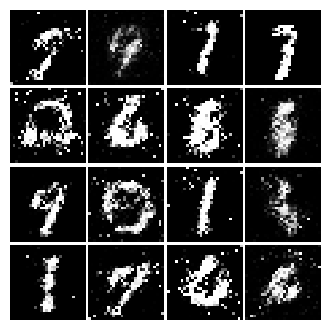


Iter: 3000, D: 1.362, G:0.8476
Iter: 3050, D: 1.38, G:0.9355
Iter: 3100, D: 1.323, G:0.853
Iter: 3150, D: 1.428, G:0.8022
Iter: 3200, D: 1.304, G:0.7473


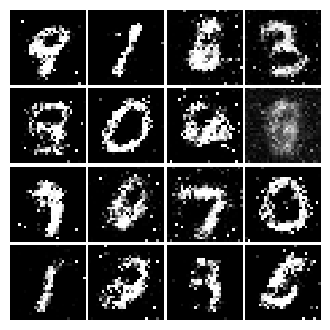


Iter: 3250, D: 1.296, G:0.7043
Iter: 3300, D: 1.336, G:0.7954
Iter: 3350, D: 1.352, G:0.7991
Iter: 3400, D: 1.401, G:0.7421
Iter: 3450, D: 1.392, G:0.7078


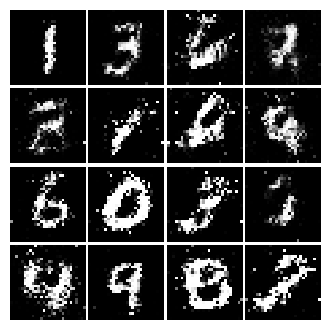


Iter: 3500, D: 1.297, G:0.6762
Iter: 3550, D: 1.376, G:0.7852
Iter: 3600, D: 1.256, G:0.79
Iter: 3650, D: 1.352, G:0.8044
Iter: 3700, D: 1.472, G:0.6781


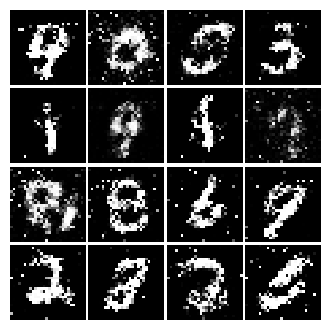


Iter: 3750, D: 1.271, G:0.784
Iter: 3800, D: 1.366, G:0.7913
Iter: 3850, D: 1.347, G:0.8257
Iter: 3900, D: 1.315, G:0.8426
Iter: 3950, D: 1.349, G:0.8889


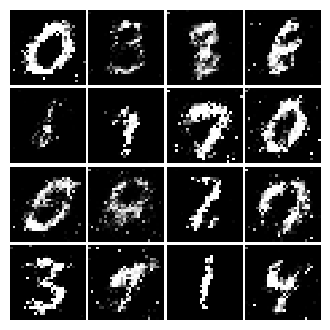


Iter: 4000, D: 1.35, G:0.784
Iter: 4050, D: 1.271, G:1.041
Iter: 4100, D: 1.376, G:1.035
Iter: 4150, D: 1.328, G:0.7822
Iter: 4200, D: 1.303, G:0.7755


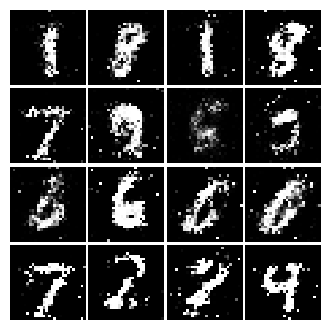


Iter: 4250, D: 1.296, G:0.7695
Final images


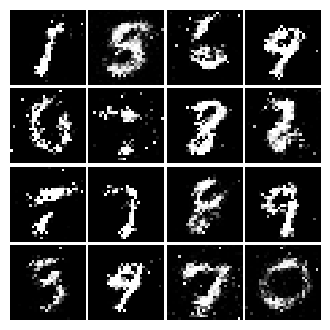

In [16]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step)

# Least Squares GAN
We'll now look at [Least Squares GAN](https://arxiv.org/abs/1611.04076), a newer, more stable alternative to the original GAN loss function. For this part, all we have to do is change the loss function and retrain the model. We'll implement equation (9) in the paper, with the generator loss:
$$\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$
and the discriminator loss:
$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$


**HINTS**: Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing. When plugging in for $D(x)$ and $D(G(z))$ use the direct output from the discriminator (`score_real` and `score_fake`).

In [17]:
def lsgan_loss(score_real, score_fake):
    """Compute the Least Squares GAN loss.
    
    Inputs:
    - score_real: Tensor, shape [batch_size, 1], output of discriminator
        score for each real image
    - score_fake: Tensor, shape[batch_size, 1], output of discriminator
        score for each fake image    
          
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    D_loss = None
    G_loss = None
    pass

    G_loss = tf.reduce_mean(tf.square(score_fake - 1)) / 2
    
    t1 = tf.reduce_mean(tf.square(score_real - 1)) / 2
    t2 = tf.reduce_mean(tf.square(score_fake)) / 2
    D_loss = t1 + t2
    
    return D_loss, G_loss

Test your LSGAN loss. You should see errors less than 1e-7.

In [18]:
def test_lsgan_loss(score_real, score_fake, d_loss_true, g_loss_true):
    with get_session() as sess:
        d_loss, g_loss = sess.run(
            lsgan_loss(tf.constant(score_real), tf.constant(score_fake)))
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_lsgan_loss(answers['logits_real'], answers['logits_fake'],
                answers['d_loss_lsgan_true'], answers['g_loss_lsgan_true'])

Maximum error in d_loss: 0
Maximum error in g_loss: 0


Create new training steps so we instead minimize the LSGAN loss:

In [19]:
D_loss, G_loss = lsgan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)

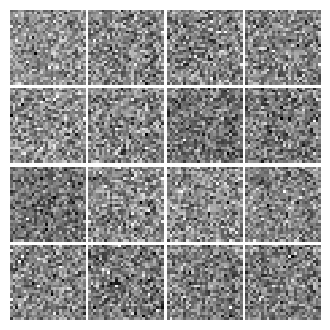


Iter: 0, D: 1.213, G:0.3788
Iter: 50, D: 0.01905, G:0.7422
Iter: 100, D: 0.3317, G:0.1099
Iter: 150, D: 0.1188, G:0.458
Iter: 200, D: 0.2094, G:0.5396


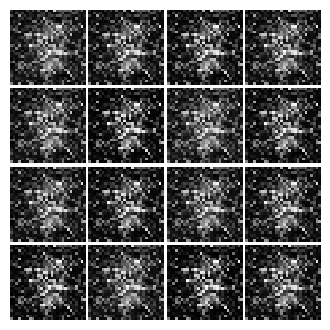


Iter: 250, D: 0.1496, G:0.5923
Iter: 300, D: 0.1192, G:0.2886
Iter: 350, D: 0.2418, G:0.3153
Iter: 400, D: 0.1443, G:0.2986
Iter: 450, D: 0.07035, G:0.4491


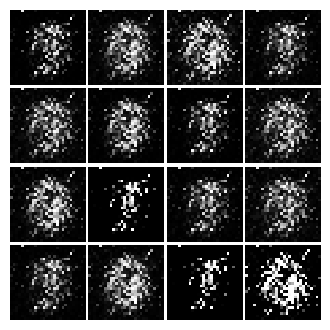


Iter: 500, D: 0.1227, G:0.5163
Iter: 550, D: 0.1629, G:0.4468
Iter: 600, D: 0.09935, G:0.4388
Iter: 650, D: 0.1098, G:0.4492
Iter: 700, D: 0.08637, G:0.5735


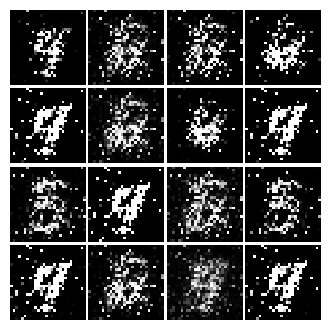


Iter: 750, D: 0.1643, G:0.291
Iter: 800, D: 0.1275, G:0.2359
Iter: 850, D: 0.07222, G:0.5741
Iter: 900, D: 0.1158, G:0.3376
Iter: 950, D: 0.3087, G:0.2766


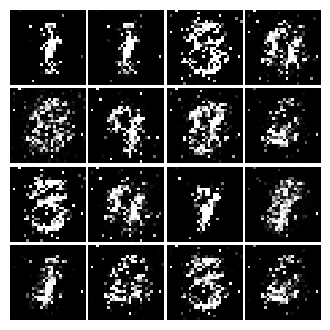


Iter: 1000, D: 0.1374, G:0.369
Iter: 1050, D: 0.153, G:0.3425
Iter: 1100, D: 0.1082, G:0.2964
Iter: 1150, D: 0.1037, G:0.3272
Iter: 1200, D: 0.1172, G:0.3449


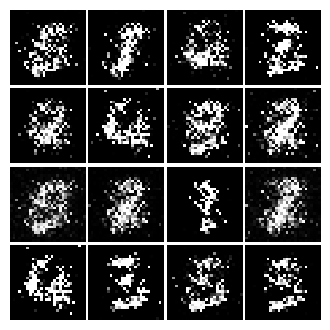


Iter: 1250, D: 0.1612, G:0.3527
Iter: 1300, D: 0.1573, G:1.597
Iter: 1350, D: 0.1492, G:0.1637
Iter: 1400, D: 0.1996, G:0.2653
Iter: 1450, D: 0.1651, G:0.2041


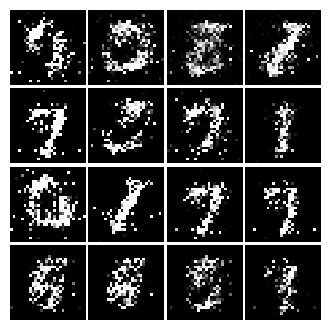


Iter: 1500, D: 0.173, G:0.1858
Iter: 1550, D: 0.1803, G:0.2477
Iter: 1600, D: 0.1975, G:0.2675
Iter: 1650, D: 0.1783, G:0.2253
Iter: 1700, D: 0.1738, G:0.2545


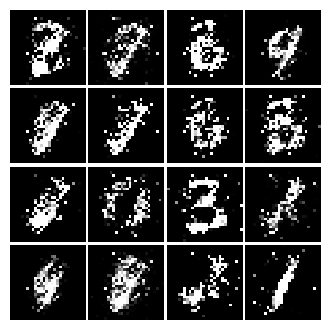


Iter: 1750, D: 0.1869, G:0.3826
Iter: 1800, D: 0.1836, G:0.21
Iter: 1850, D: 0.1914, G:0.206
Iter: 1900, D: 0.1797, G:0.2416
Iter: 1950, D: 0.2009, G:0.1958


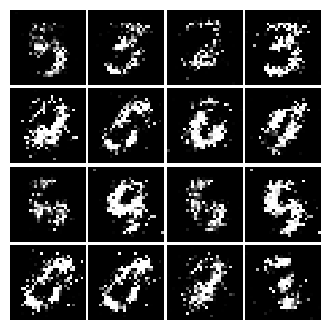


Iter: 2000, D: 0.1985, G:0.2333
Iter: 2050, D: 0.2164, G:0.2662
Iter: 2100, D: 0.2044, G:0.1907
Iter: 2150, D: 0.2006, G:0.2067
Iter: 2200, D: 0.2117, G:0.1931


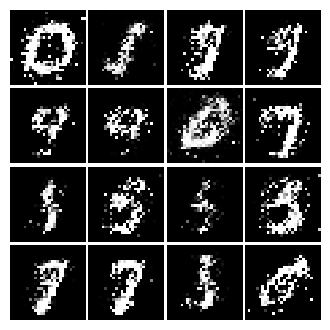


Iter: 2250, D: 0.2294, G:0.1848
Iter: 2300, D: 0.2386, G:0.1699
Iter: 2350, D: 0.2211, G:0.1722
Iter: 2400, D: 0.2225, G:0.1834
Iter: 2450, D: 0.2182, G:0.1747


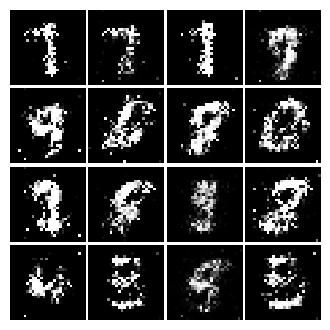


Iter: 2500, D: 0.229, G:0.1862
Iter: 2550, D: 0.2228, G:0.1849
Iter: 2600, D: 0.2395, G:0.3421
Iter: 2650, D: 0.2351, G:0.1597
Iter: 2700, D: 0.2368, G:0.1629


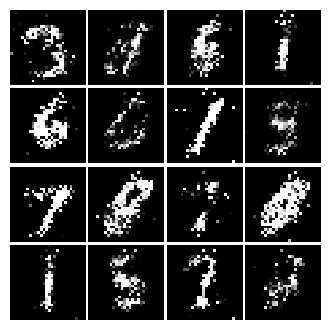


Iter: 2750, D: 0.214, G:0.1689
Iter: 2800, D: 0.2303, G:0.1798
Iter: 2850, D: 0.2425, G:0.1917
Iter: 2900, D: 0.2321, G:0.1652
Iter: 2950, D: 0.2236, G:0.1606


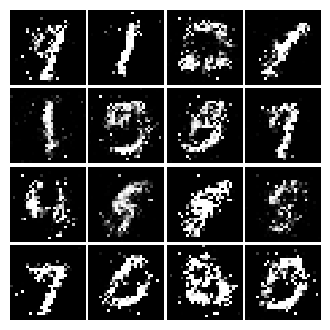


Iter: 3000, D: 0.2179, G:0.1651
Iter: 3050, D: 0.2268, G:0.1552
Iter: 3100, D: 0.2372, G:0.1892
Iter: 3150, D: 0.2303, G:0.1612
Iter: 3200, D: 0.2329, G:0.1471


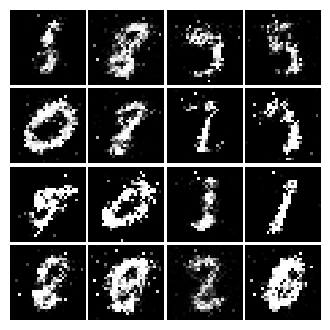


Iter: 3250, D: 0.236, G:0.171
Iter: 3300, D: 0.2188, G:0.1638
Iter: 3350, D: 0.2327, G:0.1612
Iter: 3400, D: 0.2208, G:0.1623
Iter: 3450, D: 0.2121, G:0.1713


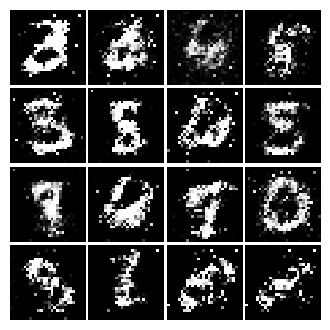


Iter: 3500, D: 0.2336, G:0.1829
Iter: 3550, D: 0.2219, G:0.18
Iter: 3600, D: 0.2436, G:0.172
Iter: 3650, D: 0.2368, G:0.1669
Iter: 3700, D: 0.2256, G:0.1711


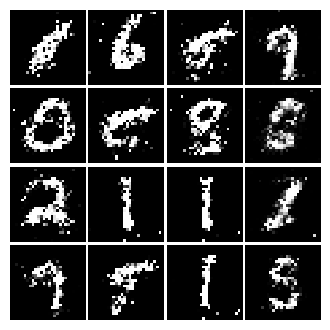


Iter: 3750, D: 0.2283, G:0.1653
Iter: 3800, D: 0.2366, G:0.1466
Iter: 3850, D: 0.2226, G:0.1891
Iter: 3900, D: 0.2309, G:0.1626
Iter: 3950, D: 0.2491, G:0.1766


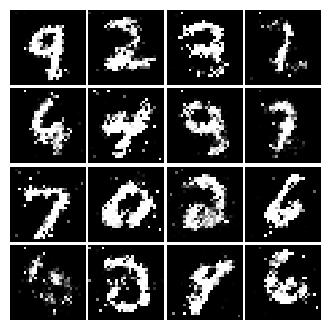


Iter: 4000, D: 0.2211, G:0.1504
Iter: 4050, D: 0.2264, G:0.1461
Iter: 4100, D: 0.2169, G:0.17
Iter: 4150, D: 0.2428, G:0.1703
Iter: 4200, D: 0.2292, G:0.221


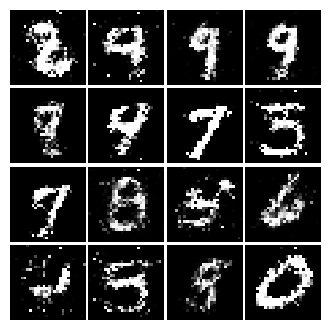


Iter: 4250, D: 0.2394, G:0.1868
Final images


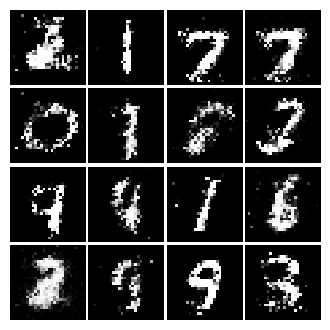

In [20]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step)

# INLINE QUESTION 1:
Describe how the visual quality of the samples changes over the course of training. Do you notice anything about the distribution of the samples? How do the results change across different training runs?

The visual quality improved over the course of training

For some digits (e.g. 4, 8), it is not doing as good 

# Deep Convolutional GANs
In the first part of the notebook, we implemented an almost direct copy of the original GAN network from Ian Goodfellow. However, this network architecture allows no real spatial reasoning. It is unable to reason about things like "sharp edges" in general because it lacks any convolutional layers. Thus, in this section, we will implement some of the ideas from [DCGAN](https://arxiv.org/abs/1511.06434), where we use convolutional networks as our discriminators and generators.

#### Discriminator
We will use a discriminator inspired by the TensorFlow MNIST classification [tutorial](https://www.tensorflow.org/get_started/mnist/pros), which is able to get above 99% accuracy on the MNIST dataset fairly quickly. *Be sure to check the dimensions of x and reshape when needed*, fully connected blocks expect [N,D] Tensors while conv2d blocks expect [N,H,W,C] Tensors. 

Architecture:
* 32 Filters, 5x5, Stride 1, Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* 64 Filters, 5x5, Stride 1, Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Flatten
* Fully Connected size 4 x 4 x 64, Leaky ReLU(alpha=0.01)
* Fully Connected size 1

In [21]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        # TODO: implement architecture
        pass
    
        x_image = tf.reshape(x, [-1,28,28,1])
        
        ##First Convolutional Layer
        W_conv1 = tf.get_variable("Wconv1", shape=[5, 5, 1, 32])
        b_conv1 = tf.get_variable("bconv1", shape=[32])
        
        h_conv1 = leaky_relu(tf.nn.conv2d(x_image, W_conv1, strides=[1, 1, 1, 1], padding='VALID') + b_conv1)
        h_pool1 = tf.nn.max_pool(h_conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
        ##Second Convolutional Layer
        W_conv2 = tf.get_variable("Wconv2", shape=[5, 5, 32, 64])
        b_conv2 = tf.get_variable("bconv2", shape=[64])
        
        h_conv2 = leaky_relu(tf.nn.conv2d(h_pool1, W_conv2, strides=[1, 1, 1, 1], padding='VALID') + b_conv2)
        h_pool2 = tf.nn.max_pool(h_conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
        #Densely Connected Layer - 1
        W_fc1 = tf.get_variable("Wfc1", shape=[4*4*64, 1024])
        b_fc1 = tf.get_variable("bfc1", shape=[1024])

        h_pool2_flat = tf.reshape(h_pool2, [-1, 4*4*64])
        h_fc1 = leaky_relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
    
        #Densely Connected Layer - 2
        W_fc2 = tf.get_variable("Wfc2", shape=[1024, 1])
        b_fc2 = tf.get_variable("bfc2", shape=[1])
        
        logits = tf.matmul(h_fc1, W_fc2) + b_fc2
    
        return logits
test_discriminator(1102721)

Correct number of parameters in discriminator.


#### Generator
For the generator, we will copy the architecture exactly from the [InfoGAN paper](https://arxiv.org/pdf/1606.03657.pdf). See Appendix C.1 MNIST. See the documentation for [tf.nn.conv2d_transpose](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose). We are always "training" in GAN mode.

Architecture:
* Fully connected of size 1024, ReLU
* BatchNorm
* Fully connected of size 7 x 7 x 128, ReLU
* BatchNorm
* Resize into Image Tensor
* 64 conv2d^T (transpose) filters of 4x4, stride 2, ReLU
* BatchNorm
* 1 conv2d^T (transpose) filter of 4x4, stride 2, TanH

In [22]:
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        # TODO: implement architecture
        pass
    
        layer1 = tf.layers.dense(inputs=z, units=1024, use_bias=True, activation=tf.nn.relu)
        bn1 = tf.contrib.layers.batch_norm(layer1)
            
        layer2 = tf.layers.dense(inputs=bn1, units=7*7*128, use_bias=True, activation=tf.nn.relu)
        bn2 = tf.contrib.layers.batch_norm(layer2)
    
        img_flat = tf.reshape(bn2, [-1, 7, 7, 128])
    
        conv1 = tf.layers.conv2d_transpose(img_flat, filters=64, use_bias=True,
                                           kernel_size=(4,4), strides=(2,2), padding='same', activation=tf.nn.relu)
        bn3 = tf.contrib.layers.batch_norm(conv1)
        
        img = tf.layers.conv2d_transpose(bn3, filters=1, use_bias=True,
                                         kernel_size=(4,4), strides=(2,2), padding='same', activation=tf.nn.tanh)
            
        return img
test_generator(6595521)

Incorrect number of parameters in generator. 6588161 instead of 6595521. Check your achitecture.


We have to recreate our network since we've changed our functions.

In [23]:
tf.reset_default_graph()

batch_size = 128
# our noise dimension
noise_dim = 96

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator') 

D_solver,G_solver = get_solvers()
D_loss, G_loss = gan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')

### Train and evaluate a DCGAN
This is the one part of A3 that significantly benefits from using a GPU. It takes 3 minutes on a GPU for the requested five epochs. Or about 50 minutes on a dual core laptop on CPU (feel free to use 3 epochs if you do it on CPU).

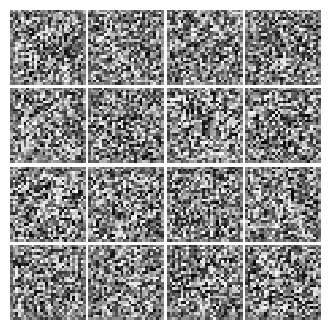


Iter: 0, D: 1.828, G:0.2722
Iter: 50, D: 0.6875, G:0.9343
Iter: 100, D: 1.91, G:1.369
Iter: 150, D: 1.068, G:0.9129
Iter: 200, D: 1.107, G:0.8762


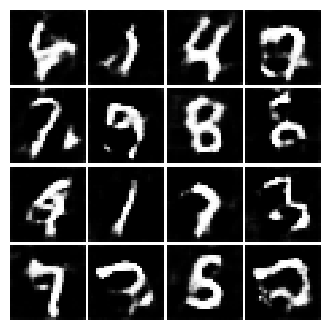


Iter: 250, D: 1.326, G:0.6358
Iter: 300, D: 1.009, G:1.095
Iter: 350, D: 1.089, G:0.5704
Iter: 400, D: 1.07, G:0.7566
Iter: 450, D: 1.183, G:1.038


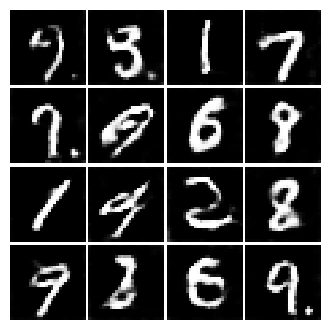


Iter: 500, D: 2.172, G:1.22
Iter: 550, D: 1.148, G:0.9753
Iter: 600, D: 1.453, G:0.8283
Iter: 650, D: 1.069, G:1.469
Iter: 700, D: 1.135, G:1.22


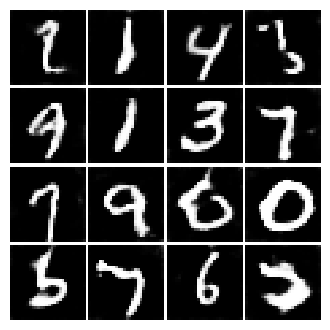


Iter: 750, D: 1.143, G:0.7349
Iter: 800, D: 1.204, G:1.463
Iter: 850, D: 1.129, G:1.49
Iter: 900, D: 1.132, G:0.951
Iter: 950, D: 1.117, G:1.204


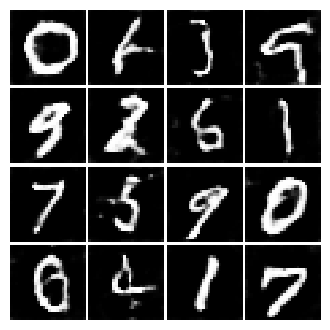


Iter: 1000, D: 1.187, G:1.004
Iter: 1050, D: 1.266, G:1.716
Iter: 1100, D: 1.156, G:0.8658
Iter: 1150, D: 1.135, G:0.9999
Iter: 1200, D: 1.291, G:0.9433


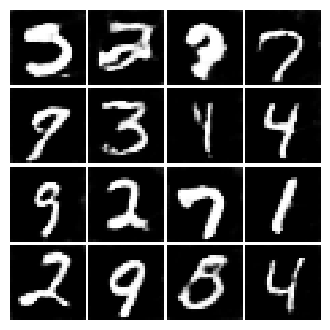


Iter: 1250, D: 1.097, G:1.216
Iter: 1300, D: 1.115, G:1.392
Iter: 1350, D: 1.163, G:0.901
Iter: 1400, D: 1.171, G:0.8768
Iter: 1450, D: 1.124, G:0.9079


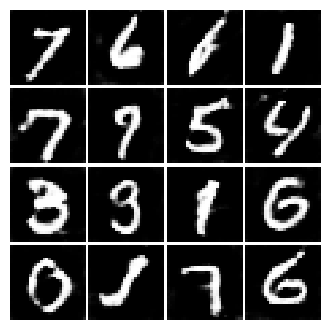


Iter: 1500, D: 1.046, G:1.13
Iter: 1550, D: 1.255, G:1.183
Iter: 1600, D: 1.067, G:0.831
Iter: 1650, D: 1.158, G:0.5724
Iter: 1700, D: 1.065, G:1.064


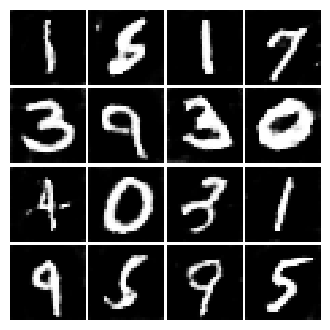


Iter: 1750, D: 1.314, G:0.7027
Iter: 1800, D: 1.056, G:1.153
Iter: 1850, D: 1.152, G:1.641
Iter: 1900, D: 1.841, G:1.18
Iter: 1950, D: 0.9639, G:0.9823


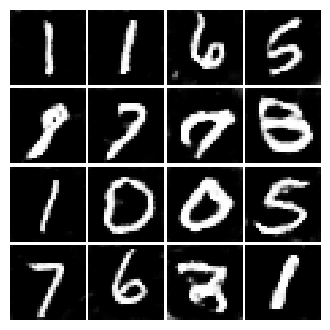


Iter: 2000, D: 1.273, G:1.691
Iter: 2050, D: 1.108, G:1.054
Iter: 2100, D: 1.548, G:0.9614
Final images


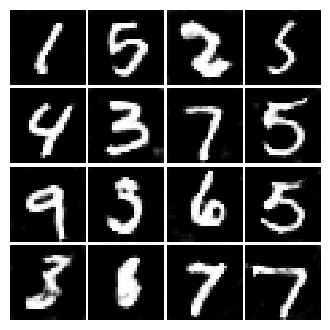

In [24]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step,num_epoch=5)

# INLINE QUESTION 2:
What differences do you see between the DCGAN results and the original GAN results?

The DCGAN images look much better.  The DCGAN images seem to generate smoother edges compared to the original GAN images